<a href="https://colab.research.google.com/github/AdriBh/JupyterNotebooks-ML-DS-AI/blob/main/CatAndDogClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cat-and-dog:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F23777%2F30378%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240203%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240203T081457Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D109abcf0bd4b72225c668d2d3e2b8d9c230f2400590541362a8875d1bf3e2bca304406aa3956d48f6ff5c016ab1000c60a12f470d4a34a3b09a680320cb740061d0d637b4682bedf45c97e2861cd9f54a9b979ef1d12700ace5bce74e55927dc38404dd4b14647f8f6b548ac09dee1061cec5aad97493058643cd5ae127be37c995cc5eb1000c332f1305108774bc97114ca0a146e745cc95b0e8fd0d0f31dce3f322d4c5821da432d762f2fa740bca500ae97be6e1e2e2a6014a2d53ea4e03616a4bb9b8573780b5bab5ffeda2540f18ae5cfa122732d552f9ce3e6af5b757713c1f087fcef20e03311f5a75c0bdb43d308582cbae073a07bc071afa1e99510'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 228487605 bytes downloaded
Downloaded and uncompressed: cat-and-dog
Data source import complete.


# Cat and Dog classification using deep nueral network
In this notebook we will create a deep nueral network which will find unique patterns and distinguish between cat and dog

## 1.Import dependencies

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import os

In [3]:
for dirpath,dirnames,filenames in os.walk("/kaggle/input/cat-and-dog"):
    print(f"There are {len(dirnames)} directories and {len(filenames)}  files in {dirpath}")

There are 2 directories and 0  files in /kaggle/input/cat-and-dog
There are 1 directories and 0  files in /kaggle/input/cat-and-dog/training_set
There are 2 directories and 0  files in /kaggle/input/cat-and-dog/training_set/training_set
There are 0 directories and 4006  files in /kaggle/input/cat-and-dog/training_set/training_set/dogs
There are 0 directories and 4001  files in /kaggle/input/cat-and-dog/training_set/training_set/cats
There are 1 directories and 0  files in /kaggle/input/cat-and-dog/test_set
There are 2 directories and 0  files in /kaggle/input/cat-and-dog/test_set/test_set
There are 0 directories and 1013  files in /kaggle/input/cat-and-dog/test_set/test_set/dogs
There are 0 directories and 1012  files in /kaggle/input/cat-and-dog/test_set/test_set/cats


In [4]:
# Getting class names
import pathlib
path = pathlib.Path("/kaggle/input/cat-and-dog/training_set/training_set")
class_names = np.array(sorted([item.name for item in path.glob("*")]))

In [5]:
class_names

array(['cats', 'dogs'], dtype='<U4')

In [6]:
os.listdir("/kaggle/input/cat-and-dog/training_set/training_set/dogs")

['dog.520.jpg',
 'dog.3583.jpg',
 'dog.432.jpg',
 'dog.1628.jpg',
 'dog.547.jpg',
 'dog.801.jpg',
 'dog.297.jpg',
 'dog.3900.jpg',
 'dog.3491.jpg',
 'dog.2616.jpg',
 'dog.3356.jpg',
 'dog.3026.jpg',
 'dog.1267.jpg',
 'dog.2770.jpg',
 'dog.2752.jpg',
 'dog.2341.jpg',
 'dog.1480.jpg',
 'dog.1588.jpg',
 'dog.3867.jpg',
 'dog.555.jpg',
 'dog.1620.jpg',
 'dog.939.jpg',
 'dog.2944.jpg',
 'dog.3405.jpg',
 'dog.2601.jpg',
 'dog.2132.jpg',
 'dog.633.jpg',
 'dog.3373.jpg',
 'dog.1653.jpg',
 'dog.3401.jpg',
 'dog.2963.jpg',
 'dog.1563.jpg',
 'dog.1915.jpg',
 'dog.1421.jpg',
 'dog.1813.jpg',
 'dog.1979.jpg',
 'dog.591.jpg',
 'dog.1227.jpg',
 'dog.717.jpg',
 'dog.799.jpg',
 'dog.2502.jpg',
 'dog.469.jpg',
 'dog.860.jpg',
 'dog.1937.jpg',
 'dog.582.jpg',
 'dog.522.jpg',
 'dog.1770.jpg',
 'dog.489.jpg',
 'dog.109.jpg',
 'dog.449.jpg',
 'dog.2081.jpg',
 'dog.3693.jpg',
 'dog.2243.jpg',
 'dog.3838.jpg',
 'dog.2843.jpg',
 'dog.3512.jpg',
 'dog.35.jpg',
 'dog.865.jpg',
 'dog.3179.jpg',
 'dog.778.jpg',
 '

In [ ]:
x = random.choice(os.listdir("/kaggle/input/cat-and-dog/training_set/training_set/dogs"))

In [ ]:
x

'dog.3765.jpg'

In [7]:
import matplotlib.image as mpimg
def view_random_images(path,class_name):
    dir = path+"/"+class_name
    for i in range(2):
        plt.subplot(1,2,i+1)
        random_image = random.choice(os.listdir(dir))
        print(random_image)
        image_path = dir +"/" + random_image
        image = mpimg.imread(image_path)
        plt.imshow(image)
        plt.title(f"Label : {class_name}")
        plt.axis("off")




dog.1911.jpg
dog.3407.jpg


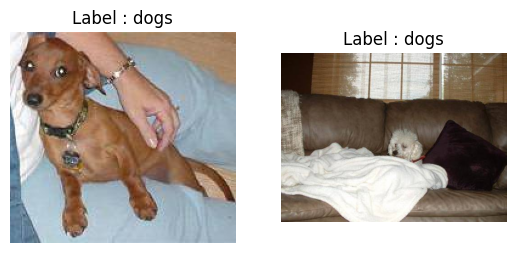

In [8]:
view_random_images("/kaggle/input/cat-and-dog/training_set/training_set/","dogs")

cat.2492.jpg
cat.2336.jpg


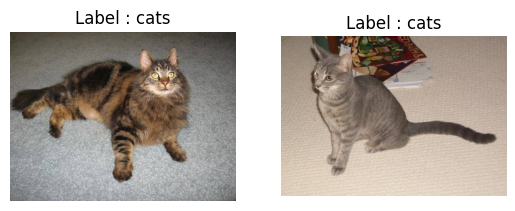

In [9]:
view_random_images("/kaggle/input/cat-and-dog/training_set/training_set/","cats")

## 2.Import data



In [22]:
train_aug_data = train_aug_datagen.flow_from_directory(train_dir,
                                                      target_size=(224,224),
                                                      class_mode="binary",
                                                       batch_size=32,
                                                       shuffle=True)


Found 8005 images belonging to 2 classes.


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_aug_datagen = ImageDataGenerator(rescale=1/255.,
                                  rotation_range=0.2,
                                  width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [19]:
def plot_loss_curves(history):
  """
  Takes history as i/p and plots loss curves
  """
  plt.figure(figsize=(10,10))
  plt.plot(history.history["loss"],label="Training Loss")
  plt.plot(history.history["val_loss"],label="Validation loss")
  plt.suptitle("Loss Curve")
  plt.legend()

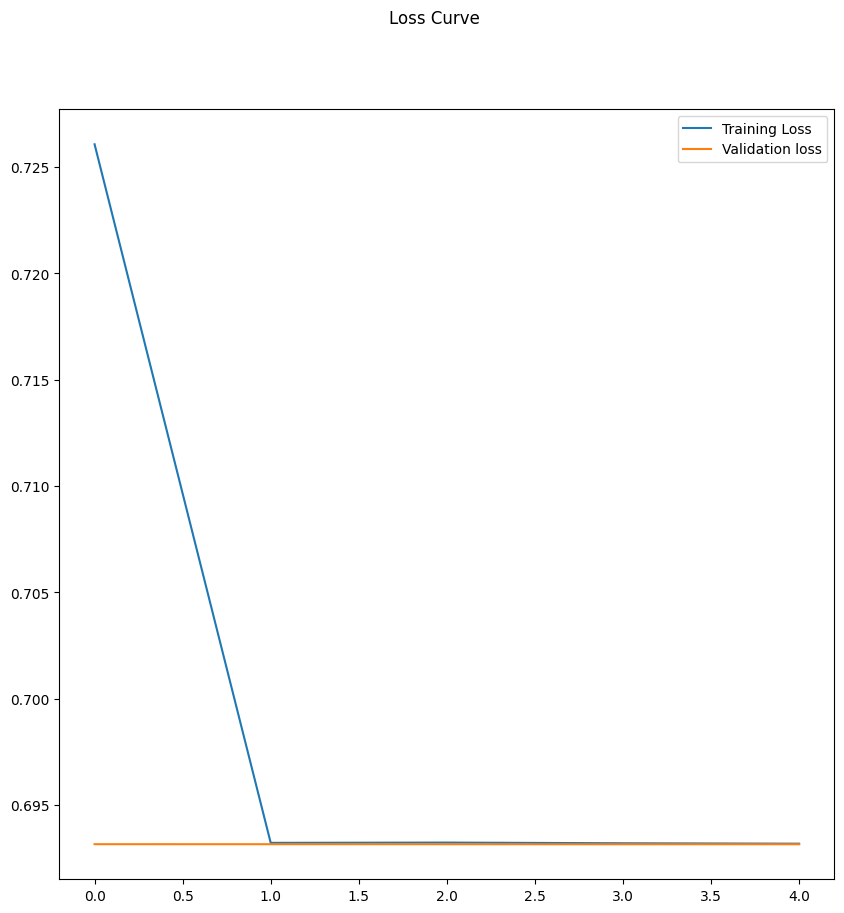

In [20]:
plot_loss_curves(hist_1)

## Baseline model (Tiny VGG)

With number of filters equal to 10

In [26]:
# Using Tiny VGG architecture
model = Sequential([
    Conv2D(10,(3,3),activation="relu",input_shape=(224,224,3)),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu",input_shape=(224,224,3)),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(1,activation="sigmoid")

])
model.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(),
             metrics=["accuracy"])



In [27]:
hist=model.fit(train_aug_data,
          epochs=5,
          steps_per_epoch=len(train_aug_data),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/5
251/251 [==============================] - 107s 411ms/step - loss: 0.6763 - accuracy: 0.5678 - val_loss: 0.6475 - val_accuracy: 0.6312
Epoch 2/5
251/251 [==============================] - 105s 419ms/step - loss: 0.6443 - accuracy: 0.6246 - val_loss: 0.6497 - val_accuracy: 0.5744
Epoch 3/5
251/251 [==============================] - 102s 406ms/step - loss: 0.6202 - accuracy: 0.6476 - val_loss: 0.5839 - val_accuracy: 0.6826
Epoch 4/5
251/251 [==============================] - 101s 404ms/step - loss: 0.6018 - accuracy: 0.6740 - val_loss: 0.5433 - val_accuracy: 0.7222
Epoch 5/5
251/251 [==============================] - 102s 405ms/step - loss: 0.5764 - accuracy: 0.6933 - val_loss: 0.5566 - val_accuracy: 0.6990


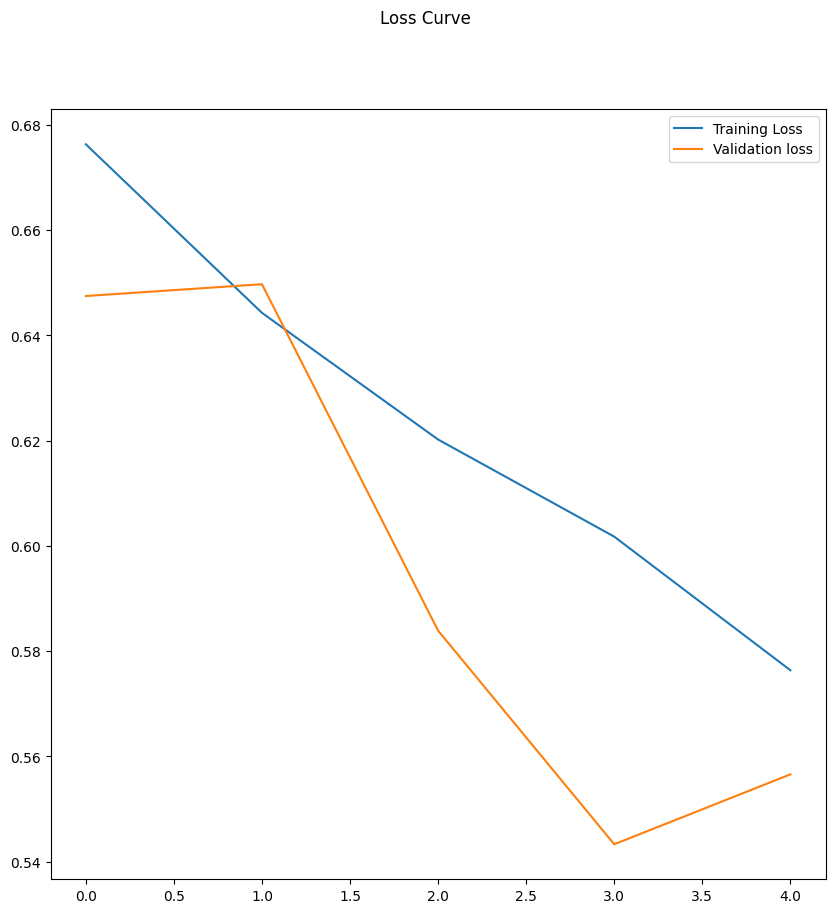

In [28]:
plot_loss_curves(hist)

## 3.Experimentation

We are gonna do the following experiments
-Increase the epoch

-Add maxpool after each conv

-We are gonna increase the Conv Block by 1

-We are gonna add another dense layer

-We are gonna change the learning rate
  
-Repeat

We are gonna clone `model` and increase the number of epoch

though our first priority will always be to decrease the time between experimentation so that naturally means lower epoch

So we gotta experiment till we find the architecture which gives better results within less epoch.

In [35]:
# Increasing number of epoch by 10
model_1 = tf.keras.models.clone_model(model)
model_1.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(),
             metrics=["accuracy"])
hist_1 = model_1.fit(train_aug_data,
          epochs=15,
          steps_per_epoch=len(train_aug_data),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/15
251/251 [==============================] - 119s 466ms/step - loss: 0.6680 - accuracy: 0.5764 - val_loss: 0.6569 - val_accuracy: 0.5675
Epoch 2/15
251/251 [==============================] - 102s 406ms/step - loss: 0.6507 - accuracy: 0.6001 - val_loss: 0.6350 - val_accuracy: 0.6105
Epoch 3/15
251/251 [==============================] - 103s 410ms/step - loss: 0.6277 - accuracy: 0.6346 - val_loss: 0.5809 - val_accuracy: 0.6752
Epoch 4/15
251/251 [==============================] - 106s 424ms/step - loss: 0.6050 - accuracy: 0.6733 - val_loss: 0.5932 - val_accuracy: 0.6831
Epoch 5/15
251/251 [==============================] - 104s 414ms/step - loss: 0.5877 - accuracy: 0.6803 - val_loss: 0.5472 - val_accuracy: 0.7202
Epoch 6/15
251/251 [==============================] - 104s 416ms/step - loss: 0.5787 - accuracy: 0.6869 - val_loss: 0.5388 - val_accuracy: 0.7187
Epoch 7/15
251/251 [==============================] - 102s 407ms/step - loss: 0.5602 - accuracy: 0.7099 - val_loss: 0.5593 -

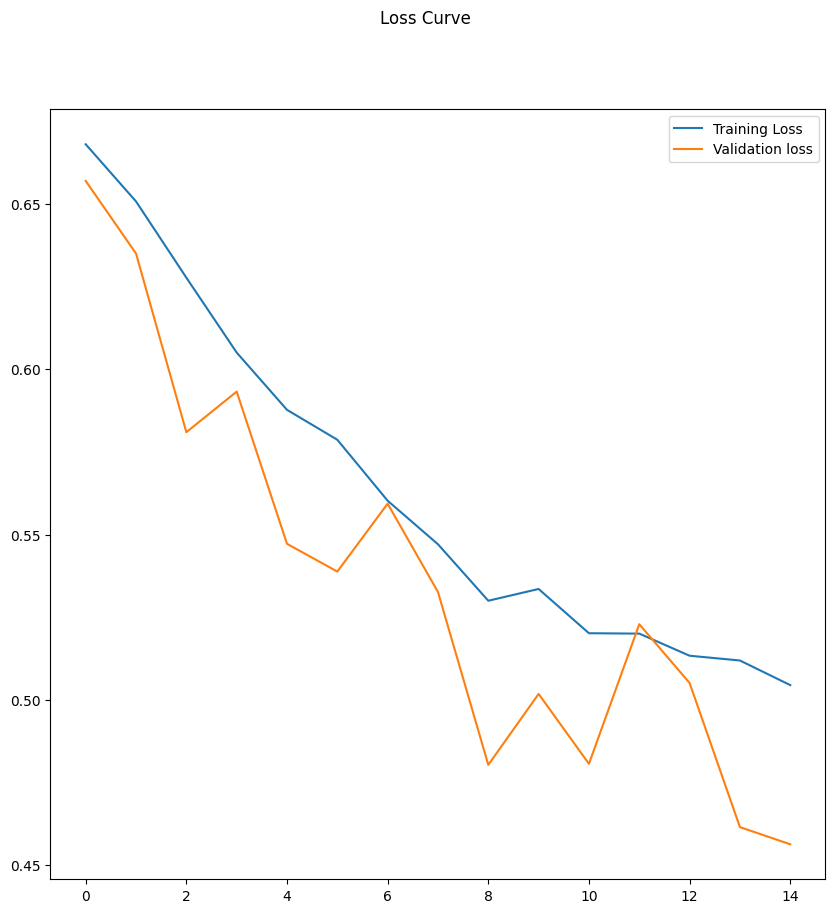

In [36]:
plot_loss_curves(hist_1)

The loss curves are heading in the right direction so if we train for longer epoch we will get the desired result

Increasing the conv block by 1

In [37]:
# Using Tiny VGG architecture
model_2 = Sequential([
    Conv2D(10,(3,3),activation="relu",input_shape=(224,224,3)),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(1,activation="sigmoid")

])
model_2.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(),
             metrics=["accuracy"])


In [38]:
hist_2 = model_2.fit(train_aug_data,
          epochs=5,
          steps_per_epoch=len(train_aug_data),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/5
251/251 [==============================] - 106s 411ms/step - loss: 0.6920 - accuracy: 0.5243 - val_loss: 0.6827 - val_accuracy: 0.5858
Epoch 2/5
251/251 [==============================] - 110s 437ms/step - loss: 0.6741 - accuracy: 0.5728 - val_loss: 0.6682 - val_accuracy: 0.5556
Epoch 3/5
251/251 [==============================] - 107s 425ms/step - loss: 0.6639 - accuracy: 0.5919 - val_loss: 0.7179 - val_accuracy: 0.5358
Epoch 4/5
251/251 [==============================] - 109s 432ms/step - loss: 0.6327 - accuracy: 0.6384 - val_loss: 0.6254 - val_accuracy: 0.6560
Epoch 5/5
251/251 [==============================] - 104s 414ms/step - loss: 0.6027 - accuracy: 0.6738 - val_loss: 0.5522 - val_accuracy: 0.7212


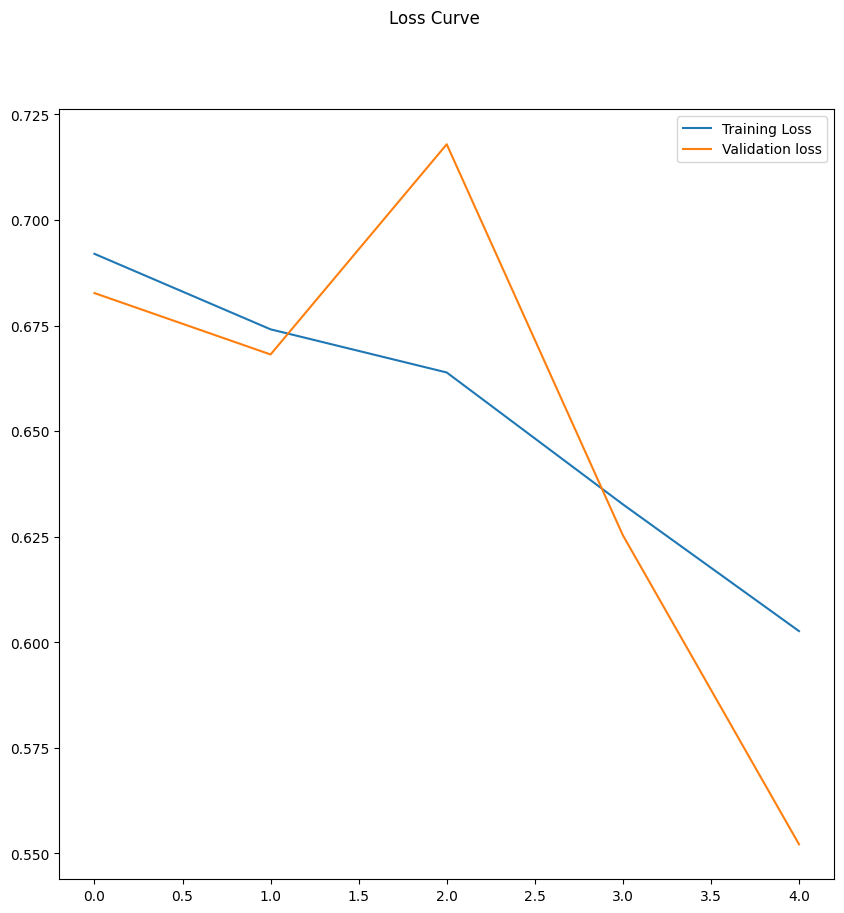

In [39]:
plot_loss_curves(hist_2)

Lets increase the number of epochs for model_2 architecture

In [42]:
model_3 = tf.keras.models.clone_model(model_2)
model_3.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(),
             metrics=["accuracy"])

In [43]:
hist_3 = model_3.fit(train_aug_data,
          epochs=15,
          steps_per_epoch=len(train_aug_data),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/15
251/251 [==============================] - 106s 413ms/step - loss: 0.6882 - accuracy: 0.5333 - val_loss: 0.6630 - val_accuracy: 0.5517
Epoch 2/15
251/251 [==============================] - 110s 437ms/step - loss: 0.6476 - accuracy: 0.6209 - val_loss: 0.6408 - val_accuracy: 0.6357
Epoch 3/15
251/251 [==============================] - 104s 413ms/step - loss: 0.6153 - accuracy: 0.6575 - val_loss: 0.6166 - val_accuracy: 0.6762
Epoch 4/15
251/251 [==============================] - 107s 424ms/step - loss: 0.5932 - accuracy: 0.6814 - val_loss: 0.5581 - val_accuracy: 0.7321
Epoch 5/15
251/251 [==============================] - 103s 409ms/step - loss: 0.5808 - accuracy: 0.6968 - val_loss: 0.5641 - val_accuracy: 0.7197
Epoch 6/15
251/251 [==============================] - 103s 412ms/step - loss: 0.5701 - accuracy: 0.7062 - val_loss: 0.5337 - val_accuracy: 0.7360
Epoch 7/15
251/251 [==============================] - 108s 431ms/step - loss: 0.5604 - accuracy: 0.7061 - val_loss: 0.5496 -

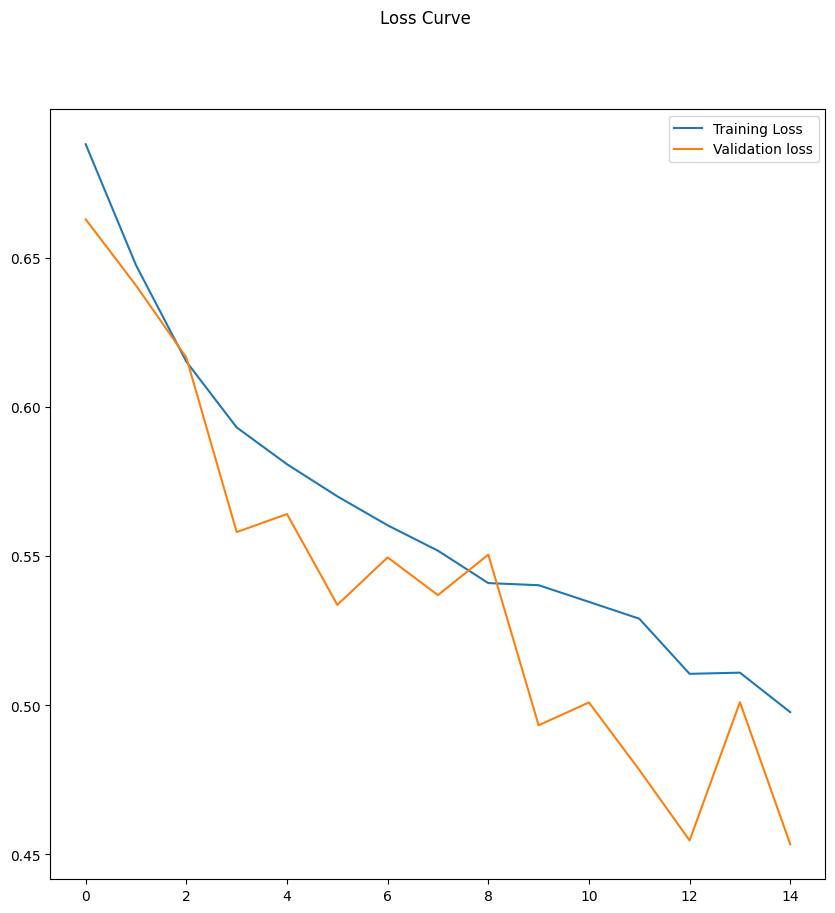

In [44]:
plot_loss_curves(hist_3)

Lets add Maxpool layers to model_2 after each conv layers to see if performance increases

In [45]:
model_4 = Sequential([
    Conv2D(10,(3,3),activation="relu",input_shape=(224,224,3)),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(1,activation="sigmoid")

])
model_4.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(),
             metrics=["accuracy"])


In [46]:
hist_4 = model_4.fit(train_aug_data,
          epochs=15,
          steps_per_epoch=len(train_aug_data),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/15
251/251 [==============================] - 103s 398ms/step - loss: 0.6910 - accuracy: 0.5275 - val_loss: 0.6806 - val_accuracy: 0.5650
Epoch 2/15
251/251 [==============================] - 100s 397ms/step - loss: 0.6685 - accuracy: 0.5921 - val_loss: 0.6517 - val_accuracy: 0.6194
Epoch 3/15
251/251 [==============================] - 99s 396ms/step - loss: 0.6414 - accuracy: 0.6335 - val_loss: 0.6233 - val_accuracy: 0.6505
Epoch 4/15
251/251 [==============================] - 101s 403ms/step - loss: 0.6221 - accuracy: 0.6572 - val_loss: 0.6296 - val_accuracy: 0.6441
Epoch 5/15
251/251 [==============================] - 103s 411ms/step - loss: 0.6072 - accuracy: 0.6683 - val_loss: 0.6088 - val_accuracy: 0.6649
Epoch 6/15
251/251 [==============================] - 101s 401ms/step - loss: 0.5890 - accuracy: 0.6898 - val_loss: 0.5797 - val_accuracy: 0.7088
Epoch 7/15
251/251 [==============================] - 100s 399ms/step - loss: 0.5729 - accuracy: 0.7037 - val_loss: 0.5736 - 

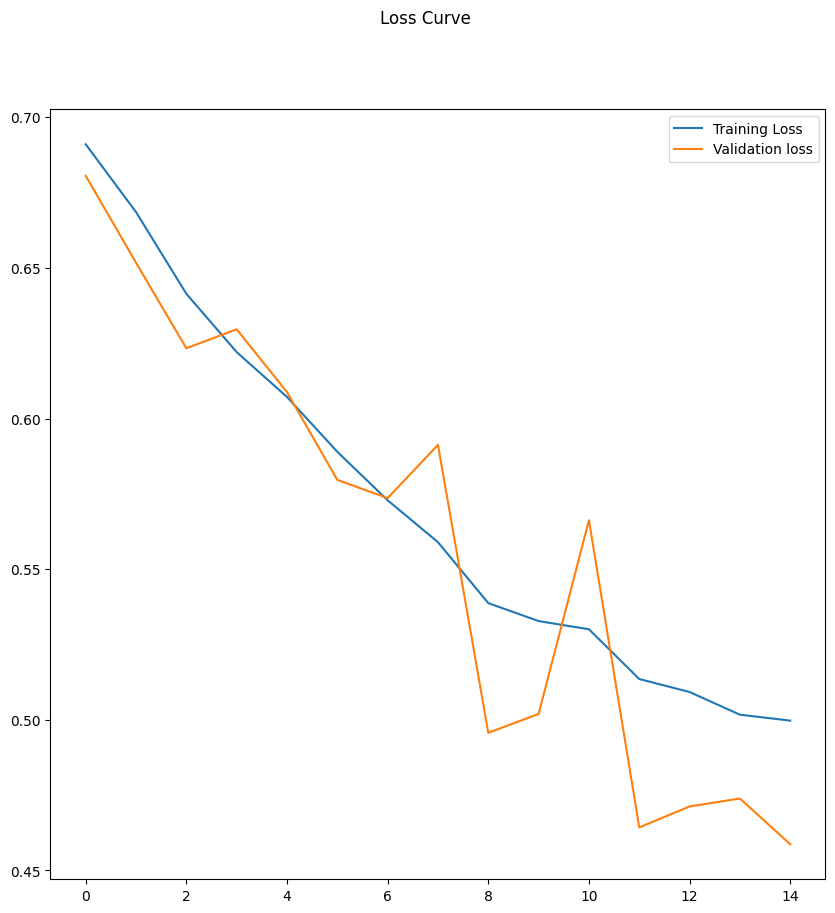

In [48]:
plot_loss_curves(hist_4)

Adding a dense layer to model_4

In [47]:
model_5 = Sequential([
    Conv2D(10,(3,3),activation="relu",input_shape=(224,224,3)),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(10,(3,3),activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(10,activation="relu"),
    Dense(1,activation="sigmoid")

])
model_5.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(),
             metrics=["accuracy"])


In [49]:
hist_5 = model_5.fit(train_aug_data,
          epochs=15,
          steps_per_epoch=len(train_aug_data),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/15
251/251 [==============================] - 112s 432ms/step - loss: 0.6929 - accuracy: 0.5210 - val_loss: 0.6905 - val_accuracy: 0.5447
Epoch 2/15
251/251 [==============================] - 100s 399ms/step - loss: 0.6876 - accuracy: 0.5492 - val_loss: 0.6753 - val_accuracy: 0.6006
Epoch 3/15
251/251 [==============================] - 105s 417ms/step - loss: 0.6668 - accuracy: 0.5993 - val_loss: 0.6596 - val_accuracy: 0.6144
Epoch 4/15
251/251 [==============================] - 101s 400ms/step - loss: 0.6383 - accuracy: 0.6384 - val_loss: 0.6400 - val_accuracy: 0.6214
Epoch 5/15
251/251 [==============================] - 100s 398ms/step - loss: 0.6223 - accuracy: 0.6517 - val_loss: 0.6070 - val_accuracy: 0.6658
Epoch 6/15
251/251 [==============================] - 100s 399ms/step - loss: 0.6020 - accuracy: 0.6753 - val_loss: 0.5828 - val_accuracy: 0.7024
Epoch 7/15
251/251 [==============================] - 102s 405ms/step - loss: 0.5887 - accuracy: 0.6897 - val_loss: 0.5641 -

We are gonna increase the number of filters in the first layer to 32 filters
then double of that in the next layer and so on

And changing the architecture a little bit by removing the last 2 convolutional layer along with the maxpooling layer.

In [50]:
model_6 = Sequential([
    Conv2D(32,(3,3),activation="relu",input_shape=(224,224,3)),
    MaxPool2D(2),
    Conv2D(64,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(128,(3,3),activation="relu"),
    MaxPool2D(2),
    Conv2D(128,(3,3),activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(128,activation="relu"),
    Dense(1,activation="sigmoid")

])
model_6.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(),
             metrics=["accuracy"])


In [51]:
hist_6 = model_6.fit(train_aug_data,
          epochs=15,
          steps_per_epoch=len(train_aug_data),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/15
251/251 [==============================] - 111s 424ms/step - loss: 0.6847 - accuracy: 0.5444 - val_loss: 0.6506 - val_accuracy: 0.6031
Epoch 2/15
251/251 [==============================] - 114s 454ms/step - loss: 0.6473 - accuracy: 0.6261 - val_loss: 0.6105 - val_accuracy: 0.6728
Epoch 3/15
251/251 [==============================] - 105s 419ms/step - loss: 0.6184 - accuracy: 0.6552 - val_loss: 0.5818 - val_accuracy: 0.6876
Epoch 4/15
251/251 [==============================] - 108s 429ms/step - loss: 0.5781 - accuracy: 0.6939 - val_loss: 0.5079 - val_accuracy: 0.7489
Epoch 5/15
251/251 [==============================] - 104s 416ms/step - loss: 0.5423 - accuracy: 0.7287 - val_loss: 0.4802 - val_accuracy: 0.7761
Epoch 6/15
251/251 [==============================] - 109s 434ms/step - loss: 0.5136 - accuracy: 0.7435 - val_loss: 0.4358 - val_accuracy: 0.8052
Epoch 7/15
251/251 [==============================] - 108s 432ms/step - loss: 0.5008 - accuracy: 0.7562 - val_loss: 0.4288 -

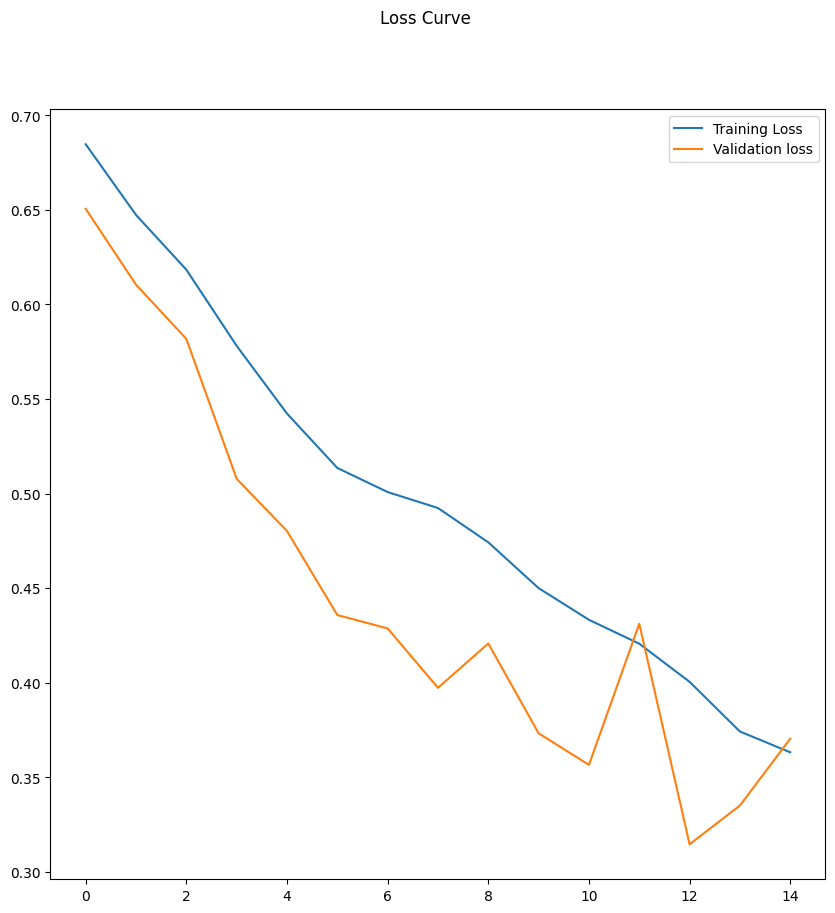

In [52]:
plot_loss_curves(hist_6)

In [54]:
preds = model_6.evaluate(test_data)

64/64 [==============================] - 4s 67ms/step - loss: 0.3705 - accuracy: 0.8428


Model 6 is getting around 84 percent accuracy so it is the best model out of the all the model we trained.

## 4.Make prediction with custom images

In [82]:
def load_and_prep_image(filename,shape=224):
  """
  Reads an image from filename,turns it into a tensor and reshapes it to
  (img_shape,img_shape,colour_channels)
  """
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img,[shape,shape])
  img = img/255.
  img = tf.expand_dims(img,axis=0)

  return img
def pred_and_plot_image(model,filename,class_name):
  img = load_and_prep_image(filename)
  preds = model.predict(img)
  formatted_preds = "{:.2f}".format(preds[0,0])
  pred_class = class_names[int(tf.round(preds))]

  plt.imshow(tf.squeeze(img))
  plt.title(f"Actual label:{class_name} , Predicted Label{pred_class}{formatted_preds}")
  plt.axis("off")

Our classifier is classing 1=dog and 0=cat.

In [58]:
from google.colab import files
for i in range(4):
  uploaded = files.upload()

Saving wildcat.jpg to wildcat.jpg


Saving OIP.jpg to OIP.jpg


Saving kitten.jpg to kitten.jpg


Saving image.jpg to image (1).jpg


In [66]:
from google.colab import files
for i in range(4):
  uploaded = files.upload()

Saving indiandog.jpg to indiandog.jpg


Saving germansheperd.jpg to germansheperd.jpg


Saving dachshund.jpg to dachshund.jpg


Saving labrador.jpg to labrador.jpg


1/1 [==============================] - 0s 18ms/step


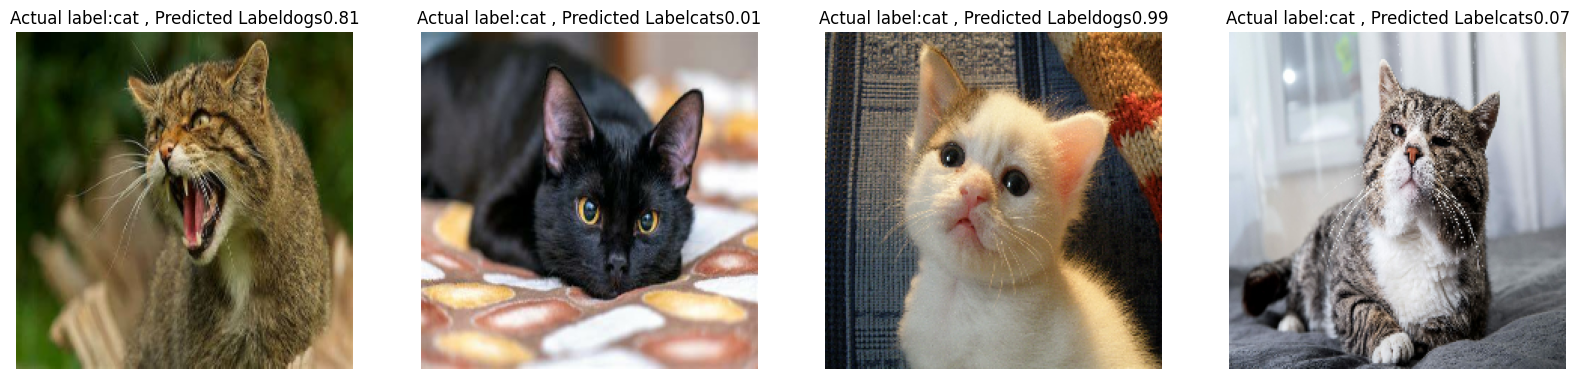

In [83]:
# Plotting the predictions of cat
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
pred_and_plot_image(model_6,"wildcat.jpg","cat")
plt.subplot(1,4,2)
pred_and_plot_image(model_6,"OIP.jpg","cat")
plt.subplot(1,4,3)
pred_and_plot_image(model_6,"kitten.jpg","cat")
plt.subplot(1,4,4)
pred_and_plot_image(model_6,"image.jpg","cat")


1/1 [==============================] - 0s 37ms/step


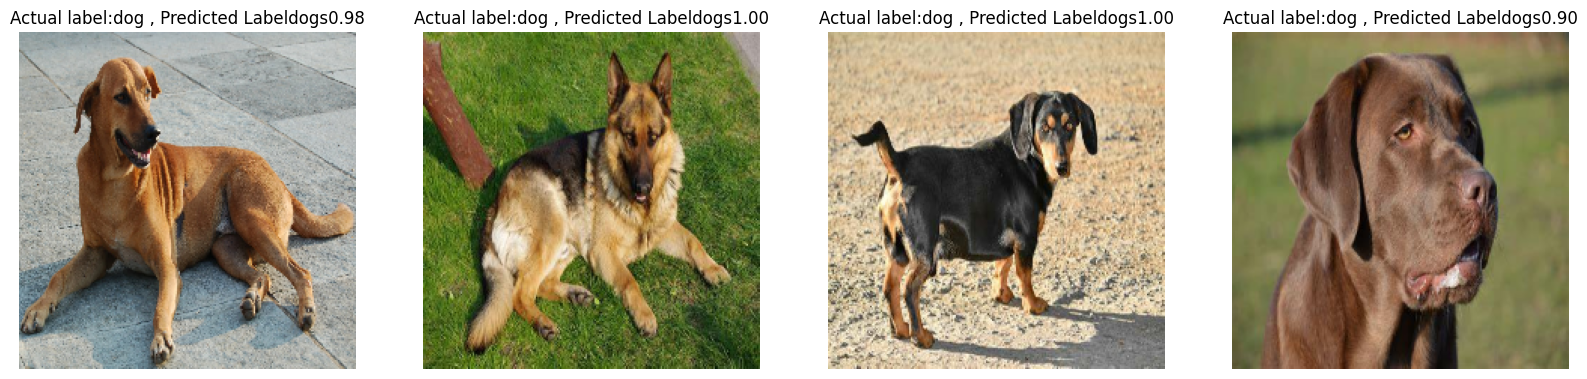

In [85]:
# Plotting the predictions of dog
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
pred_and_plot_image(model_6,"indiandog.jpg","dog")
plt.subplot(1,4,2)
pred_and_plot_image(model_6,"germansheperd.jpg","dog")
plt.subplot(1,4,3)
pred_and_plot_image(model_6,"dachshund.jpg","dog")
plt.subplot(1,4,4)
pred_and_plot_image(model_6,"labrador.jpg","dog")

In [84]:
class_names

array(['cats', 'dogs'], dtype='<U4')

## 5.Plotting Confusion Matrix

In [104]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


In [99]:
y = test_data.labels

In [110]:
y,len(y)

(array([0, 0, 0, ..., 1, 1, 1], dtype=int32), 2023)

In [87]:
preds = model_6.predict(test_data)

64/64 [==============================] - 6s 85ms/step


In [91]:
preds = tf.round(preds)

In [92]:
preds =tf.cast(preds,dtype=tf.int32)

In [101]:
c_m = confusion_matrix(y,preds)

In [103]:
c_m

array([[406, 605],
       [385, 627]])

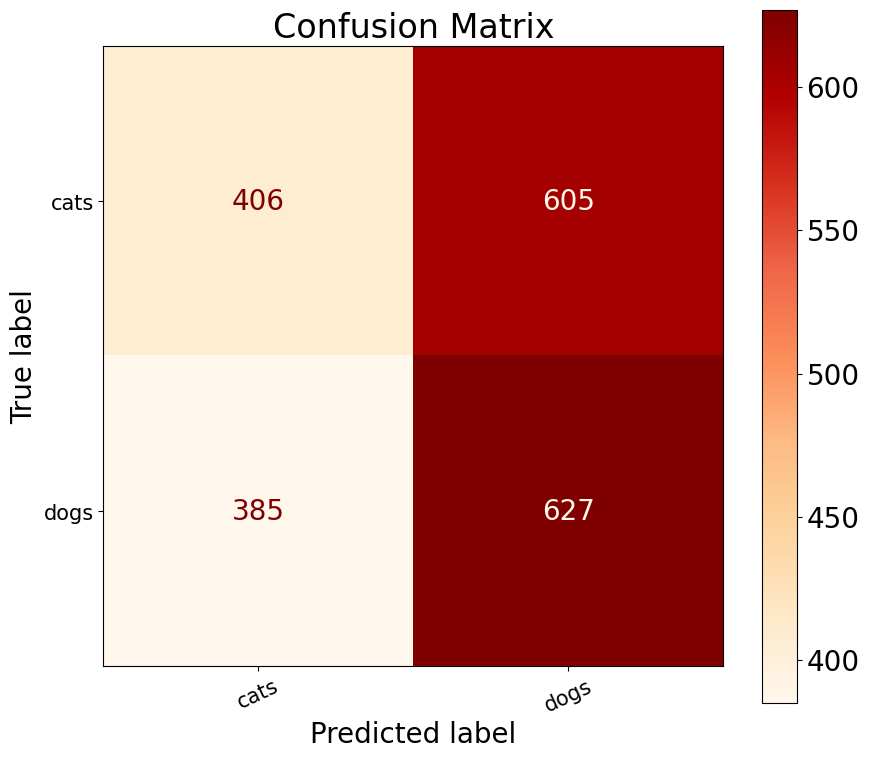

In [106]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline


# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=class_names)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)


# Showing the plot
plt.show()

In [109]:
from sklearn.metrics import classification_report
print(classification_report(y,preds))

              precision    recall  f1-score   support

           0       0.51      0.40      0.45      1011
           1       0.51      0.62      0.56      1012

    accuracy                           0.51      2023
   macro avg       0.51      0.51      0.50      2023
weighted avg       0.51      0.51      0.50      2023



Conclusion:

Our model is getting confused regarding the attributes of cats..